In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
os.chdir("../..")


In [27]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable


In [4]:
from qml.tools.random import XRandomGenerator


In [18]:
class TargetFunctionGenerator:

    NUM_POINT_TO_NORMALIZER = 500

    def __init__(self, seed: int = None):
        self.rng = XRandomGenerator(seed)
    
    @classmethod
    def wrap_with_normalizer(cls, func: Callable) -> Callable:
        xs = np.linspace(-1, 1, cls.NUM_POINT_TO_NORMALIZER)
        ys = np.asarray(func(xs))
        ymax = ys.max()
        ymin = ys.min()
        dys = ymax - ymin
        
        def normalizer(xs):
            base = func(xs)
            ys = (base - ymin) / dys * 2 - 1
            return ys
        
        return normalizer

    def generate(self, require_info: bool = False):
        bf, finfo = self.base_func()
        wrapped_func = self.wrap_with_normalizer(bf)
        if not require_info:
            return wrapped_func
        return wrapped_func, finfo
    
    def base_func(self):
        raise NotImplementedError()


In [25]:
class PolynominalTargetFunctionGenerator(TargetFunctionGenerator):

    def __init__(self, max_order: int, seed: int = None):
        super().__init__(seed)
        self._max_order = max_order
    
    def base_func(self):
        coefs = self.rng.normal(0, 1, size=(self._max_order, 1))
        def bf(xs):
            powered_xs = np.vstack([
                np.power(xs, n + 1)
                for n in range(self._max_order)
            ])
            ys = (powered_xs * coefs).sum(axis=0)
            return ys
        return bf, dict(coefs=coefs.flatten())


In [122]:
class TrigonometricTargetFuncGenerator(TargetFunctionGenerator):

    def __init__(self, max_frequency: int, seed: int = None):
        super().__init__(seed)
        self._max_frequency = max_frequency
    
    def base_func(self):
        fmax = self._max_frequency
        flags_select = self.rng.choice([0, 1], size=[2 * (fmax + 1), 1], replace=True)
        coefficients = self.rng.normal(0., 1., size=[2 * (fmax + 1), 1])
        coefficients = flags_select * coefficients

        def bf(xs):
            stacked_xs = np.vstack([xs for _ in range(fmax+1)])
            sin_cos = np.vstack([np.sin(stacked_xs), np.cos(stacked_xs)])
            ys = (sin_cos * coefficients).sum(axis=0)
            return ys
        
        return bf, dict(coefs=coefficients)


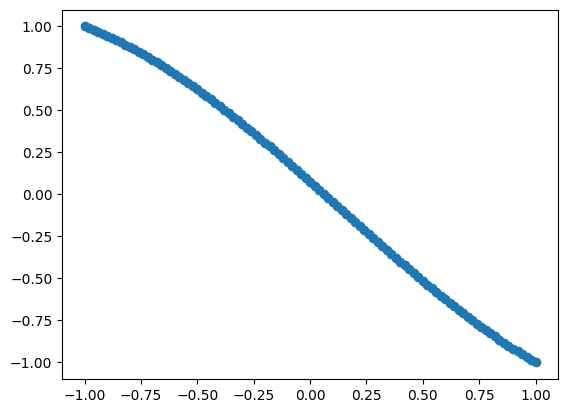

In [123]:
fgen = TrigonometricTargetFuncGenerator(5)
func = fgen.generate()

xs = np.linspace(-1, 1, 101)
ys = func(xs)
plt.scatter(xs, ys)


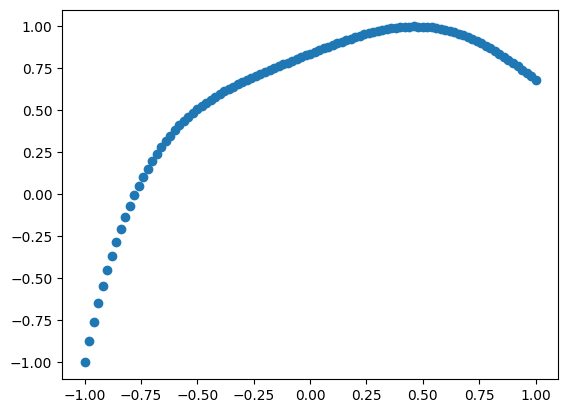

In [125]:
fgen = PolynominalTargetFunctionGenerator(5)
func = fgen.generate()

xs = np.linspace(-1, 1, 101)
ys = func(xs)
plt.scatter(xs, ys)
